# Deuterium experiment 2020-02-28 Analysis

The purpose of this notebook is to analyse correlations between the temperature and input heating current of the `20200228-D-experiment` experiment to see whether increases in reactor temperature are as a result of internal processes or external changes in the input power.

This is the first experiment in which I am able to measure the temperature and the input current (and hence power) at the same time. 

More details on this experiment can be found at the [blog page](https://gitlab.com/mklilley/lenr/issues/4#note_297632479).

The data can be found in the repo at [/data/20200228-NiMesh-PdBurnish-D](../../data/20200228-NiMesh-PdBurnish-D).

## Libraries

In [9]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Source the data

In [10]:
df = pd.read_csv("../../data/20200228-NiMesh-PdBurnish-D/20200228-NiMesh-PdBurnish-D.csv",parse_dates=["time(s)"], 
                 date_parser=lambda row: pd.to_datetime(row, unit='s'))

## Explore and transform the data

Because the current data is collected from a different Arduino to the other sensors, it's not always possible to have all readings at the same time. This leads to some NaNs in the data.

In [11]:
df.head()

time(s)  current(A)  pressure(Pa)  temperature(C)  ambientT(C)
0 2020-02-28 09:36:03       0.012           NaN             NaN          NaN
1 2020-02-28 09:36:13       0.012           NaN             NaN          NaN
2 2020-02-28 09:36:23       0.012           NaN             NaN          NaN
3 2020-02-28 09:36:24         NaN       57143.0            16.5        19.17
4 2020-02-28 09:36:33       0.012           NaN             NaN          NaN

We eventually want to do some cross correlation calculations on temperature and current so we need values of both at the same time. We shall therefore interpolate the data linearly. The data are only a few seconds apart at most and things don't change that much on that time scale so it seems reasonable.

Before we interpolate, we'll save the raw temperature and current data in order to do some histogram plots later

In [12]:
current = df["current(A)"]
temperature = df["temperature(C)"]
df.interpolate(limit_direction="both", inplace=True)

In [13]:
df.head()

time(s)  current(A)  pressure(Pa)  temperature(C)  ambientT(C)
0 2020-02-28 09:36:03       0.012       57143.0            16.5        19.17
1 2020-02-28 09:36:13       0.012       57143.0            16.5        19.17
2 2020-02-28 09:36:23       0.012       57143.0            16.5        19.17
3 2020-02-28 09:36:24       0.012       57143.0            16.5        19.17
4 2020-02-28 09:36:33       0.012       60714.5            16.5        19.17

Let's get a quick look at the current data

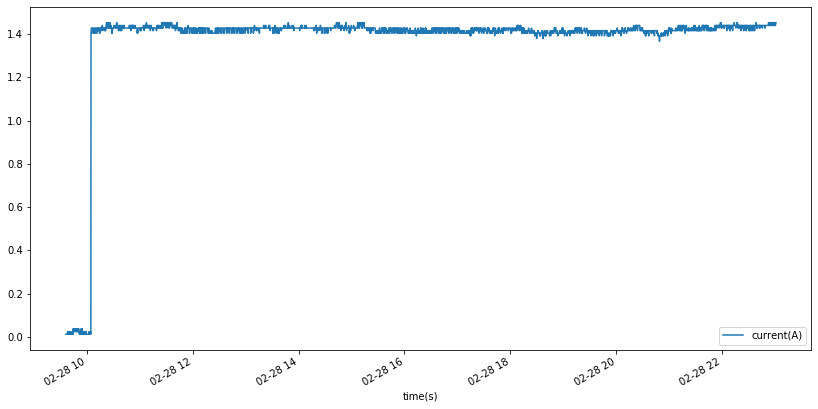

In [14]:
df.plot(x="time(s)",y="current(A)",figsize=(14,7));

And now the temperature data

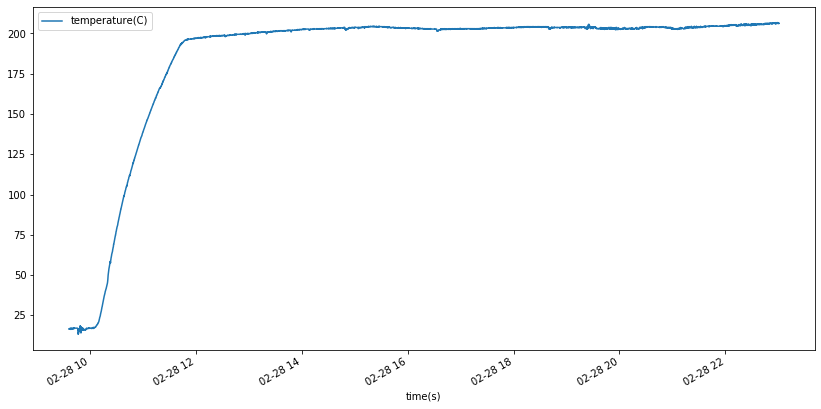

In [15]:
df.plot(x="time(s)",y="temperature(C)",figsize=(14,7));

It took many hours for the temperature to stop rising. This was at about 15:15. Let's focus on time periods greater than this.

In [16]:
df_backup = df.copy()

In [17]:
times = df_backup["time(s)"] > "2020-02-28 15:15"
df = df_backup[times]

It will also be helpful to smooth the data a little because the current in particular is quite spiky. The data is supposed too be collected every 10s most of the time, but there are several factors which change this
1. The current sensor is not aligned in timing with the other sensor
2. There are times when the temperature/pressure/ambientT is collected every 500ms when new deuterium is added (at about 19:30).

This means a moving average of 30 should be 5 mins but will likely be more 2.5 most of the time. For now I don't think it is too important - we just want to get a better visual sense of things.

In [18]:
df["average current(A)"] = df_backup["current(A)"].rolling(30,center=True).mean()
df["average temperature(C)"] = df_backup["temperature(C)"].rolling(30,center=True).mean()

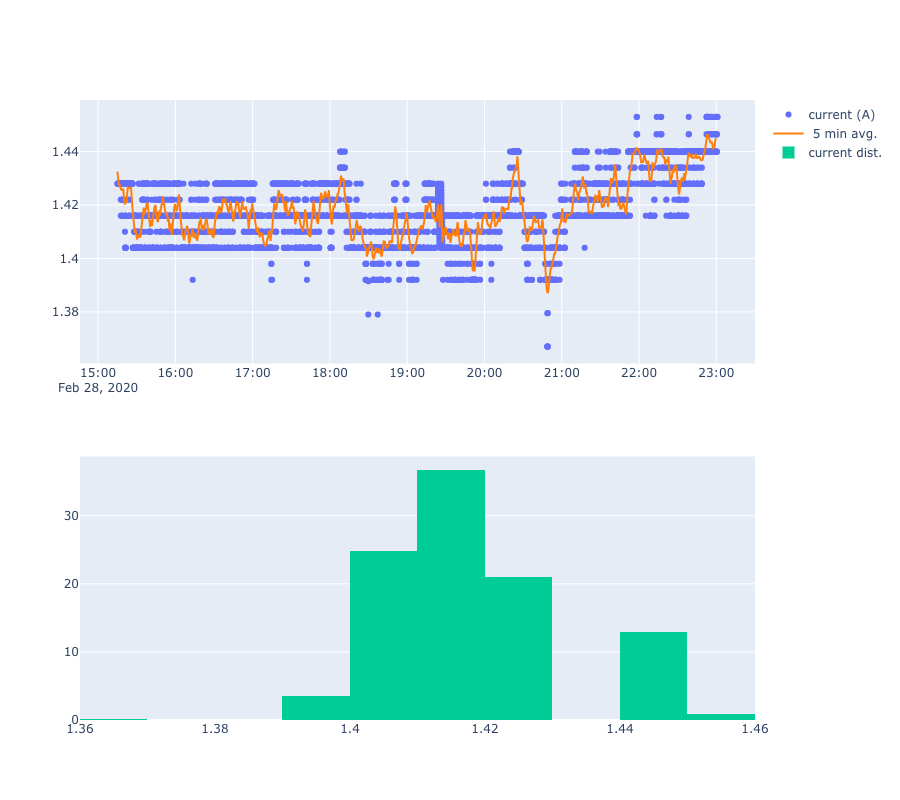

In [19]:
fig = make_subplots(rows=2, cols=1)

# First plot the data
fig.add_trace(go.Scatter(x=df["time(s)"], y=df["current(A)"],
                    mode='markers',
                    name='current (A)' ), row=1,col=1)

# Secondly plot the model
fig.add_trace(go.Scatter(x=df["time(s)"], y=df["average current(A)"],
                    mode='lines', 
                    name=' 5 min avg.',opacity=1,line_color="#ff7f0e"), row=1,col=1)


fig.add_trace(go.Histogram(x=current[times],histnorm='percent', name="current dist."), row=2,col=1)


fig.show(renderer="png",width=900, height=800)

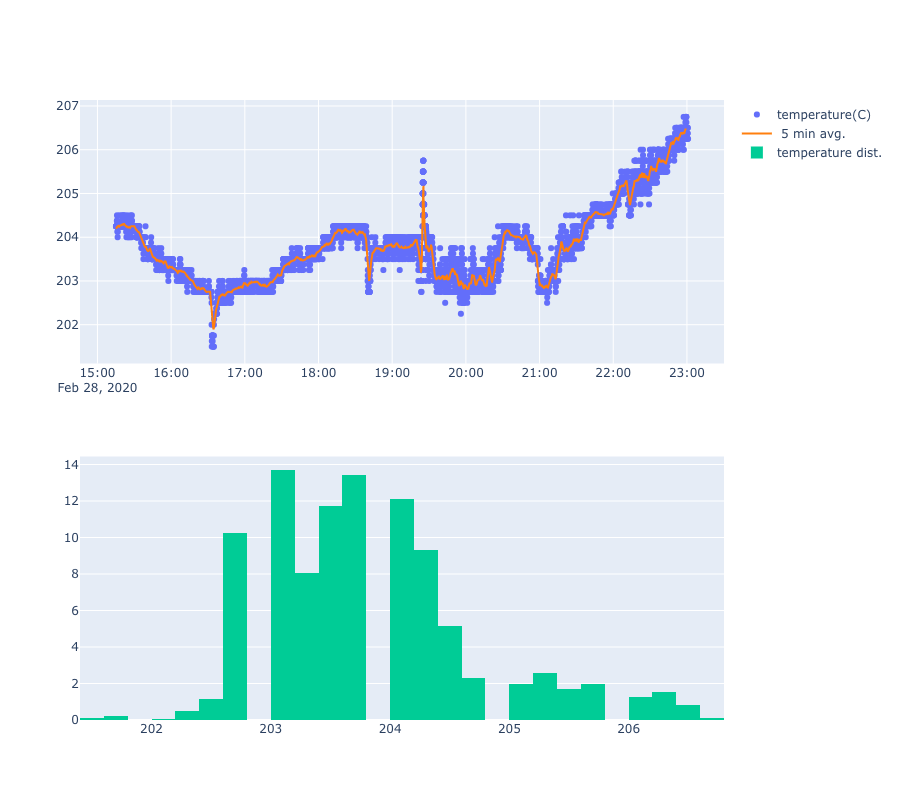

In [20]:
fig = make_subplots(rows=2, cols=1)

# First plot the data
fig.add_trace(go.Scatter(x=df["time(s)"], y=df["temperature(C)"],
                    mode='markers',
                    name='temperature(C)' ), row=1,col=1)

fig.add_trace(go.Scatter(x=df["time(s)"], y=df["average temperature(C)"],
                    mode='lines', 
                    name=' 5 min avg.',opacity=1,line_color="#ff7f0e"), row=1,col=1)


fig.add_trace(go.Histogram(x=temperature[times],histnorm='percent', name="temperature dist."), row=2,col=1)


fig.show(renderer="png",width=900, height=800)

Let's try and plot the smoothed current and the smoothed temperature on the same scale to see if we can see any correlation with our eyes. To do this we will normalise the data by subtracting the mean and dividing by the standard deviation.

In [21]:
df["norm. avg. current"] = ((df["current(A)"] - df["current(A)"].mean())/df["current(A)"].std()).rolling(30,center=True).mean()
df["norm. avg. temp"] = ((df["temperature(C)"] - df["temperature(C)"].mean())/df["temperature(C)"].std()).rolling(30,center=True).mean()

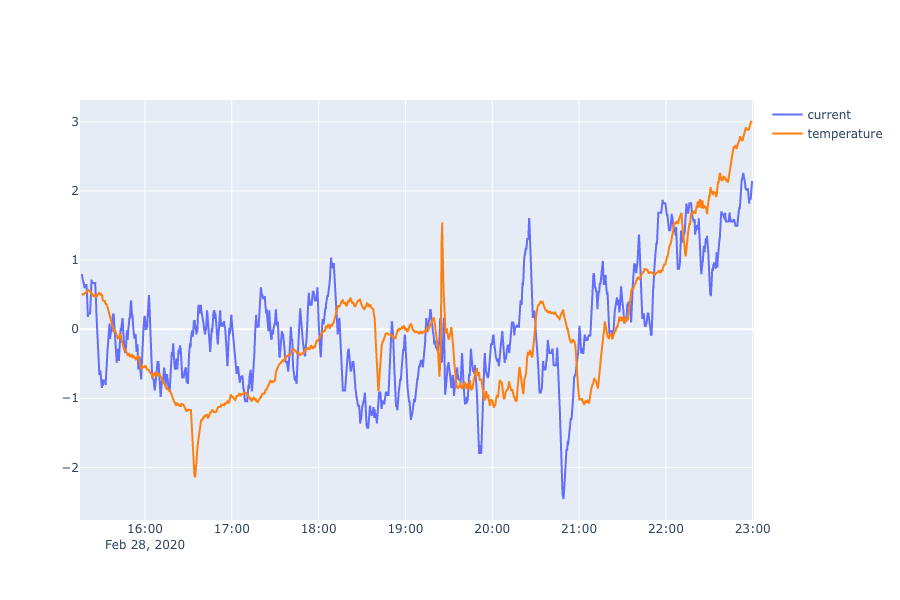

In [22]:
fig = fig = go.Figure()

# First plot the data
fig.add_trace(go.Scatter(x=df["time(s)"], y=df["norm. avg. current"],
                    mode='lines',
                    name='current' ))

fig.add_trace(go.Scatter(x=df["time(s)"], y=df["norm. avg. temp"],
                    mode='lines',
                    name='temperature', line_color="#ff7f0e" ))


fig.show(renderer="png",width=900, height=600)
# fig.show(width=900, height=600)

There is definitely some correlation between the signals and in particular the temperature changes lag behind the changes in heating current. This is what you'd expect - it takes time for the reactor to respond to changes in the environment.

Let's try and be quantitative about the correlation we see with our eyes.

## Correlation analysis

Because we have already taken the time to normalise our data, we can straight away use [numpy's correlate function](https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html) which calculates the [cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation) between two signals.

The documentation can be a bit confusing - I found [this stack overflow post](https://stackoverflow.com/questions/49372282/find-the-best-lag-from-the-numpy-correlate-output
) helpful.

In [23]:
len_temp = len(df["norm. avg. temp"].dropna())
c = np.correlate(df["norm. avg. temp"].dropna(), df["norm. avg. current"].dropna(), mode="full")
c = c / len_temp

In [24]:
lag_shift = len_temp - 1
lags = np.arange(0,len(c)) - lag_shift

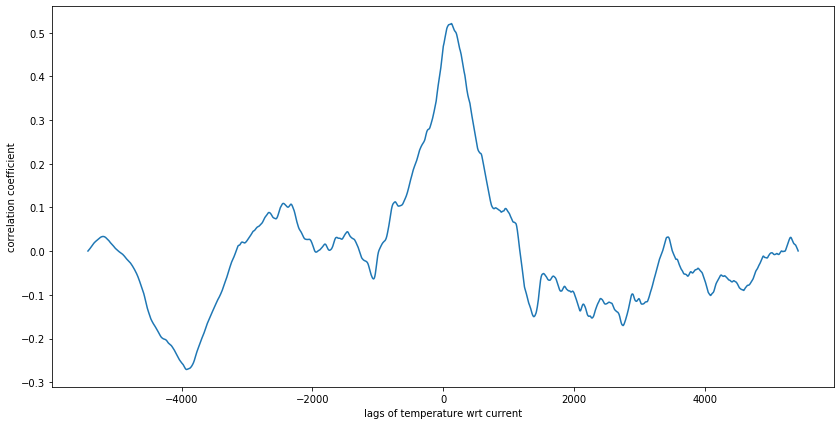

In [25]:
plt.figure(figsize=(14,7))
plt.plot(lags,c)
plt.xlabel("lags of temperature wrt current");
plt.ylabel("correlation coefficient");

We can see that there is peak in the correlation when the signals are somewhat shifted from each other. This is consistent with what we saw by eye earlier. We can extract this maximum correlation.

In [26]:
c[c.argmax()]

0.5206944282504578

And we can calculate how shifted the temperature is compared to the current.

In [27]:
c.argmax() - lag_shift

127

The temperature lags behind the current by 127 time units. We can shift the temperature by -127 units to bring them in sync.

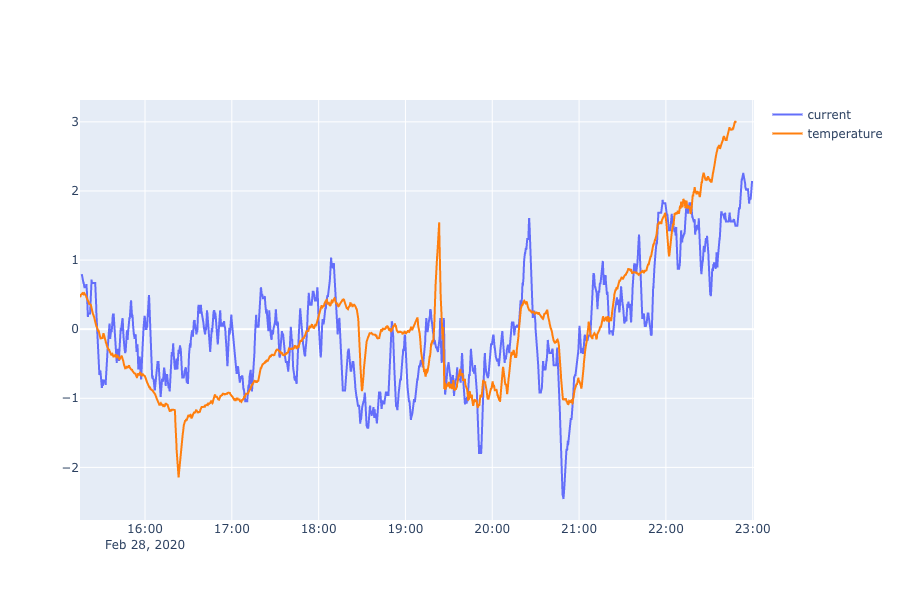

In [28]:
fig = fig = go.Figure()

# First plot the data
fig.add_trace(go.Scatter(x=df["time(s)"], y=df["norm. avg. current"],
                    mode='lines',
                    name='current' ))

fig.add_trace(go.Scatter(x=df["time(s)"], y=df["norm. avg. temp"].shift(-127),
                    mode='lines',
                    name='temperature', line_color="#ff7f0e" ))


fig.show(renderer="png",width=900, height=600)
# fig.show(width=900, height=600)

We can also do the correlation analysis on the unsmoothed data just to make sure we didn't add anything dodgy in the smoothing process.

In [29]:
df["norm. current"] = ((df["current(A)"] - df["current(A)"].mean())/df["current(A)"].std())
df["norm. temp"] = ((df["temperature(C)"] - df["temperature(C)"].mean())/df["temperature(C)"].std())

In [30]:
len_temp = len(df["norm. temp"])
c = np.correlate(df["norm. temp"], df["norm. current"], mode="full")/len_temp
c[c.argmax()]

0.5475799101443553

The correlation is slightly larger now.

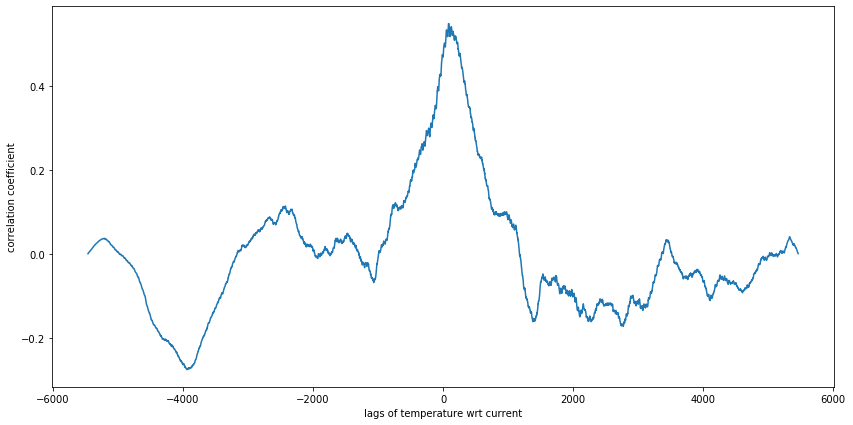

In [33]:
lag_shift = len_temp - 1
lags = np.arange(0,len(c)) - lag_shift
plt.figure(figsize=(14,7))
plt.plot(lags,c)
plt.xlabel("lags of temperature wrt current");
plt.ylabel("correlation coefficient");

In [32]:
c.argmax() - lag_shift

84

And the shift is not so large.

nothing appears to be massively different from using the smoothed data.